# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import os

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu118
True


In [ ]:
# !curl -O http://www.soshnikov.com/permanent/data/petfaces.tar.gz
# !tar xfz petfaces.tar.gz
# !del petfaces.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 28 23.3M   28 6740k    0     0  9631k      0  0:00:02 --:--:--  0:00:02 9643k
 67 23.3M   67 15.7M    0     0  9458k      0  0:00:02  0:00:01  0:00:01 9464k
100 23.3M  100 23.3M    0     0  9406k      0  0:00:02  0:00:02 --:--:-- 9413k


Для визуализации списка изображений можно использовать такую функцию:

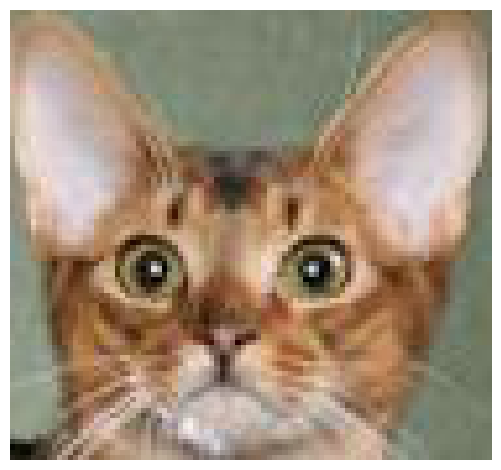

In [6]:
def display_images(l, titles=None, fontsize=12):
    n = len(l)
    fig, ax = plt.subplots(1, n)
    
    if n == 1:
        ax = [ax]
    
    for i, im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i], fontsize=fontsize)
    
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

image_folder = "petfaces/cat_Abyssinian"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
images = [Image.open(file) for file in image_files]
images = [np.array(img) for img in images]
single_image = [images[0]]

display_images(single_image)

In [ ]:
data_dir = './petfaces'

# Определение преобразований для аугментации и нормализации
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # В PyTorch нет RandomZoom, но можно реализовать через Resize + Crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка данных
dataset = ImageFolder(root=data_dir, transform=transform)

# Разделение данных на обучающую и тестовую выборки
train_indices, val_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class PetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PetClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
num_classes = len(dataset.classes)
model = PetClassifier(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Обучение модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch 1/20, Train Loss: 2.1891, Train Acc: 0.3583, Val Loss: 2.2926, Val Acc: 0.3919
Epoch 2/20, Train Loss: 1.7910, Train Acc: 0.4708, Val Loss: 2.0865, Val Acc: 0.4339
Epoch 3/20, Train Loss: 1.5262, Train Acc: 0.5615, Val Loss: 1.9191, Val Acc: 0.4541
Epoch 4/20, Train Loss: 1.3555, Train Acc: 0.6063, Val Loss: 1.8015, Val Acc: 0.5054
Epoch 5/20, Train Loss: 1.2055, Train Acc: 0.6488, Val Loss: 1.7653, Val Acc: 0.5194
Epoch 6/20, Train Loss: 1.0573, Train Acc: 0.6830, Val Loss: 1.9153, Val Acc: 0.5117
Epoch 7/20, Train Loss: 0.9314, Train Acc: 0.7095, Val Loss: 1.7565, Val Acc: 0.5334
Epoch 8/20, Train Loss: 0.8170, Train Acc: 0.7500, Val Loss: 1.8326, Val Acc: 0.5365
Epoch 9/20, Train Loss: 0.7754, Train Acc: 0.7597, Val Loss: 1.7477, Val Acc: 0.5910
Epoch 10/20, Train Loss: 0.6566, Train Acc: 0.7936, Val Loss: 1.8552, Val Acc: 0.5428
Epoch 11/20, Train Loss: 0.6439, Train Acc: 0.7998, Val Loss: 1.9225, Val Acc: 0.5397
Epoch 12/20, Train Loss: 0.5203, Train Acc: 0.8357, Val Loss: 1

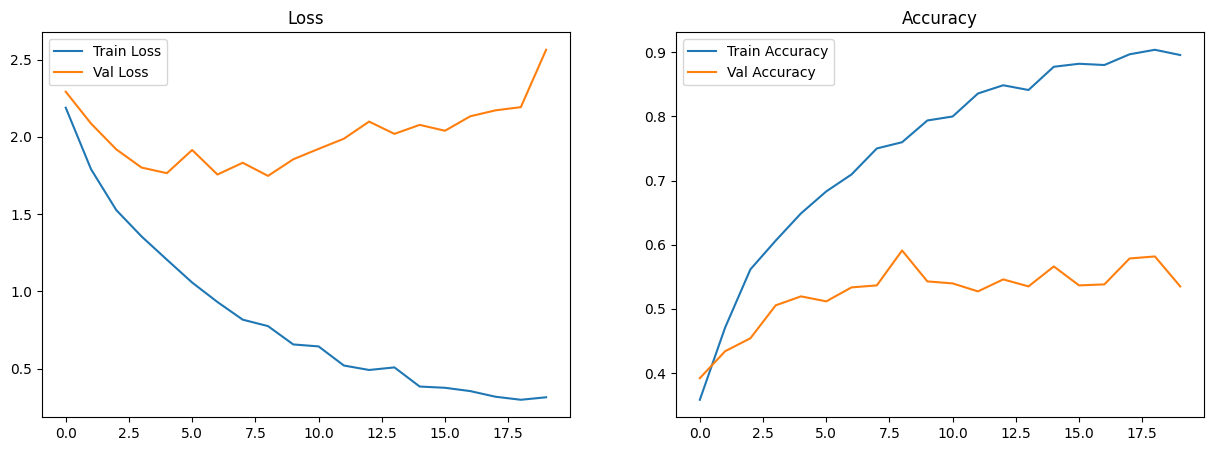

In [14]:
# Построение графиков
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [15]:
# Точность бинарной классификации (кошки vs собаки)
def binary_accuracy(model, loader):
    cats_classes = list(range(12))  # Индексы классов кошек
    dogs_classes = list(range(12, 35))  # Индексы классов собак
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                if (predicted[i] in cats_classes and labels[i] in cats_classes) or \
                   (predicted[i] in dogs_classes and labels[i] in dogs_classes):
                    correct += 1
                total += 1
    
    return correct / total

binary_acc = binary_accuracy(model, val_loader)
print(f'Cats vs Dogs Accuracy: {binary_acc:.4f}')

Cats vs Dogs Accuracy: 0.9222


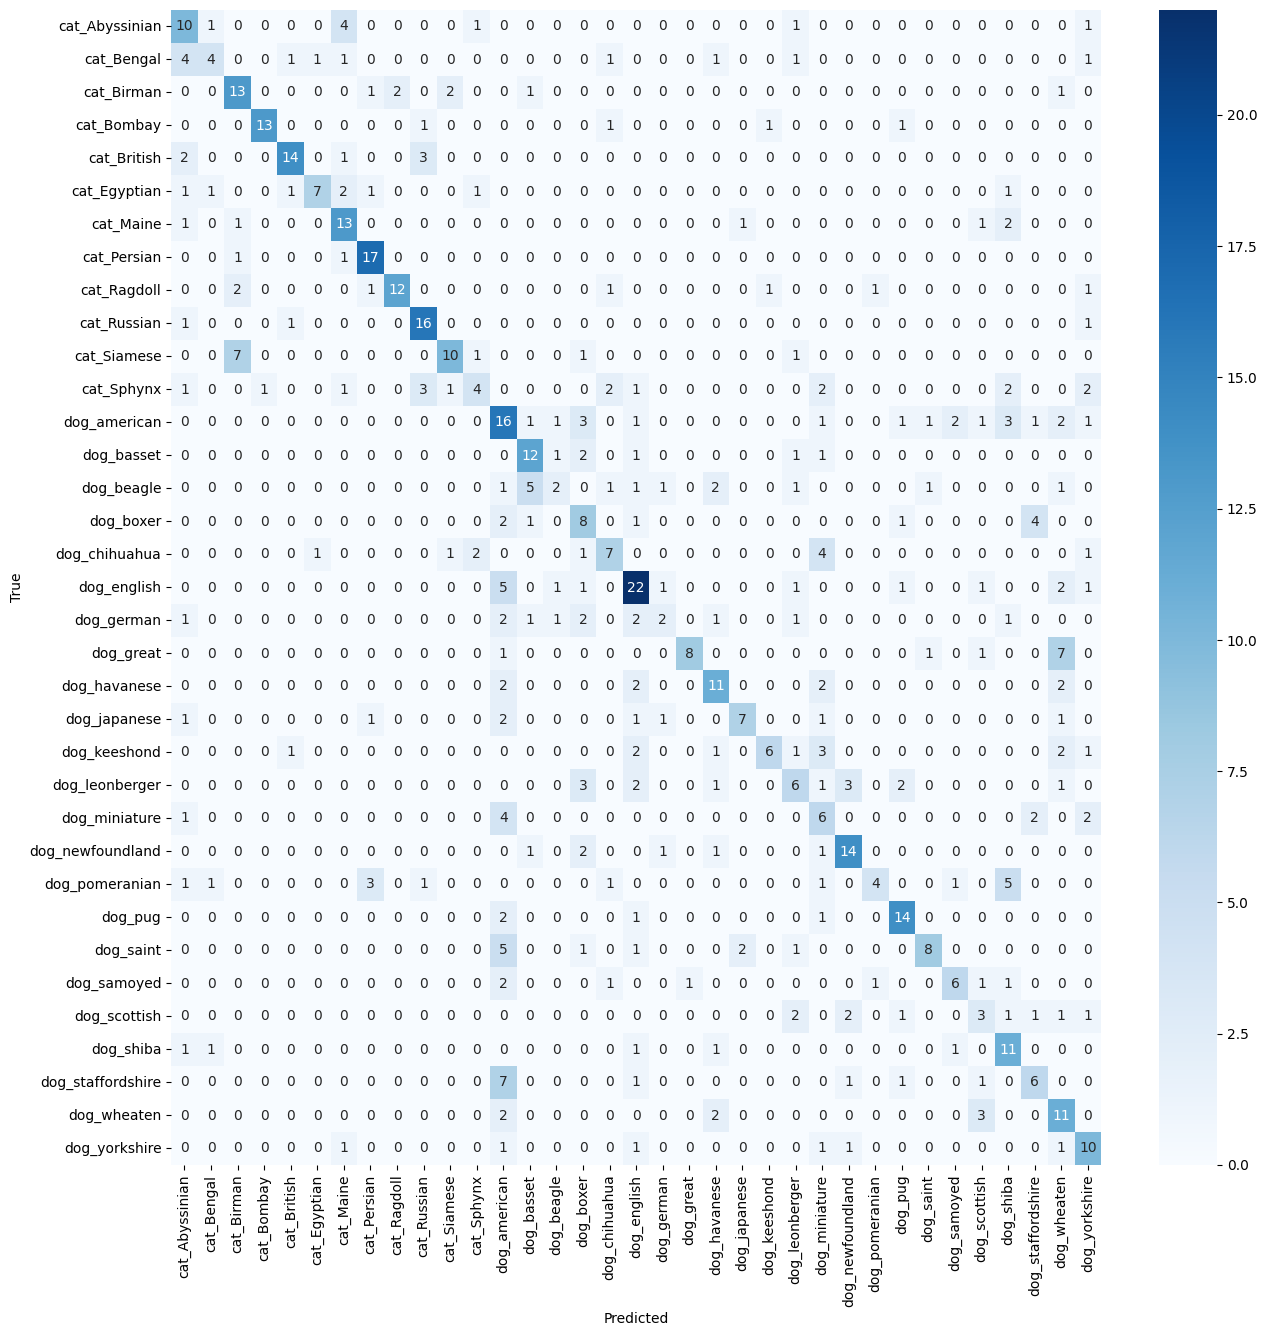

In [16]:
# Confusion Matrix
def plot_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, val_loader)

In [17]:
# Top-3 Accuracy
def top_k_accuracy(model, loader, k=3):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, topk = torch.topk(outputs, k, dim=1)
            for i in range(len(labels)):
                if labels[i] in topk[i]:
                    correct += 1
                total += 1
    
    return correct / total

top3_acc = top_k_accuracy(model, val_loader, k=3)
print(f'Top-3 Accuracy: {top3_acc:.4f}')

Top-3 Accuracy: 0.7496


## Как дополнительную оптимизацию использую предобученную модель (ResNet18)

In [22]:
def create_pretrained_model(num_classes):
    weights = ResNet18_Weights.IMAGENET1K_V1  # Используем веса, обученные на ImageNet
    model = resnet18(weights=weights)  # Загружаем модель с весами
    num_ftrs = model.fc.in_features  # Получаем количество входных признаков последнего слоя
    model.fc = nn.Linear(num_ftrs, num_classes)  # Заменяем последний слой на новый для нашей задачи
    return model

In [ ]:
num_classes = len(dataset.classes)
model = create_pretrained_model(num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

riterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Меньший learning rate для fine-tuning

In [25]:
# Обучение модели
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch 1/20, Train Loss: 1.5448, Train Acc: 0.6336, Val Loss: 0.6229, Val Acc: 0.8538
Epoch 2/20, Train Loss: 0.4734, Train Acc: 0.8945, Val Loss: 0.4368, Val Acc: 0.8849
Epoch 3/20, Train Loss: 0.2645, Train Acc: 0.9431, Val Loss: 0.3878, Val Acc: 0.8911
Epoch 4/20, Train Loss: 0.1665, Train Acc: 0.9743, Val Loss: 0.3326, Val Acc: 0.9082
Epoch 5/20, Train Loss: 0.1081, Train Acc: 0.9840, Val Loss: 0.3406, Val Acc: 0.8927
Epoch 6/20, Train Loss: 0.0642, Train Acc: 0.9907, Val Loss: 0.3278, Val Acc: 0.8989
Epoch 7/20, Train Loss: 0.0537, Train Acc: 0.9926, Val Loss: 0.3043, Val Acc: 0.9020
Epoch 8/20, Train Loss: 0.0495, Train Acc: 0.9910, Val Loss: 0.3519, Val Acc: 0.8958
Epoch 9/20, Train Loss: 0.0384, Train Acc: 0.9953, Val Loss: 0.3539, Val Acc: 0.8942
Epoch 10/20, Train Loss: 0.0442, Train Acc: 0.9910, Val Loss: 0.3332, Val Acc: 0.9160
Epoch 11/20, Train Loss: 0.0381, Train Acc: 0.9938, Val Loss: 0.3090, Val Acc: 0.9129
Epoch 12/20, Train Loss: 0.0393, Train Acc: 0.9934, Val Loss: 0

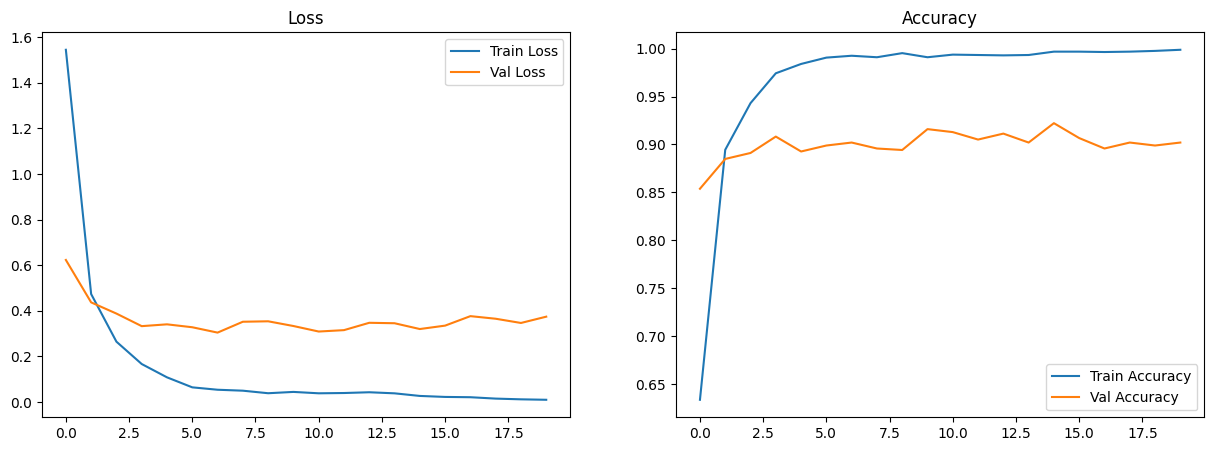

In [26]:
# Построение графиков
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [27]:
# Точность бинарной классификации (кошки vs собаки)
def binary_accuracy(model, loader):
    cats_classes = list(range(12))  # Индексы классов кошек
    dogs_classes = list(range(12, 35))  # Индексы классов собак
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                if (predicted[i] in cats_classes and labels[i] in cats_classes) or \
                   (predicted[i] in dogs_classes and labels[i] in dogs_classes):
                    correct += 1
                total += 1
    
    return correct / total

binary_acc = binary_accuracy(model, val_loader)
print(f'Cats vs Dogs Accuracy: {binary_acc:.4f}')

Cats vs Dogs Accuracy: 0.9907


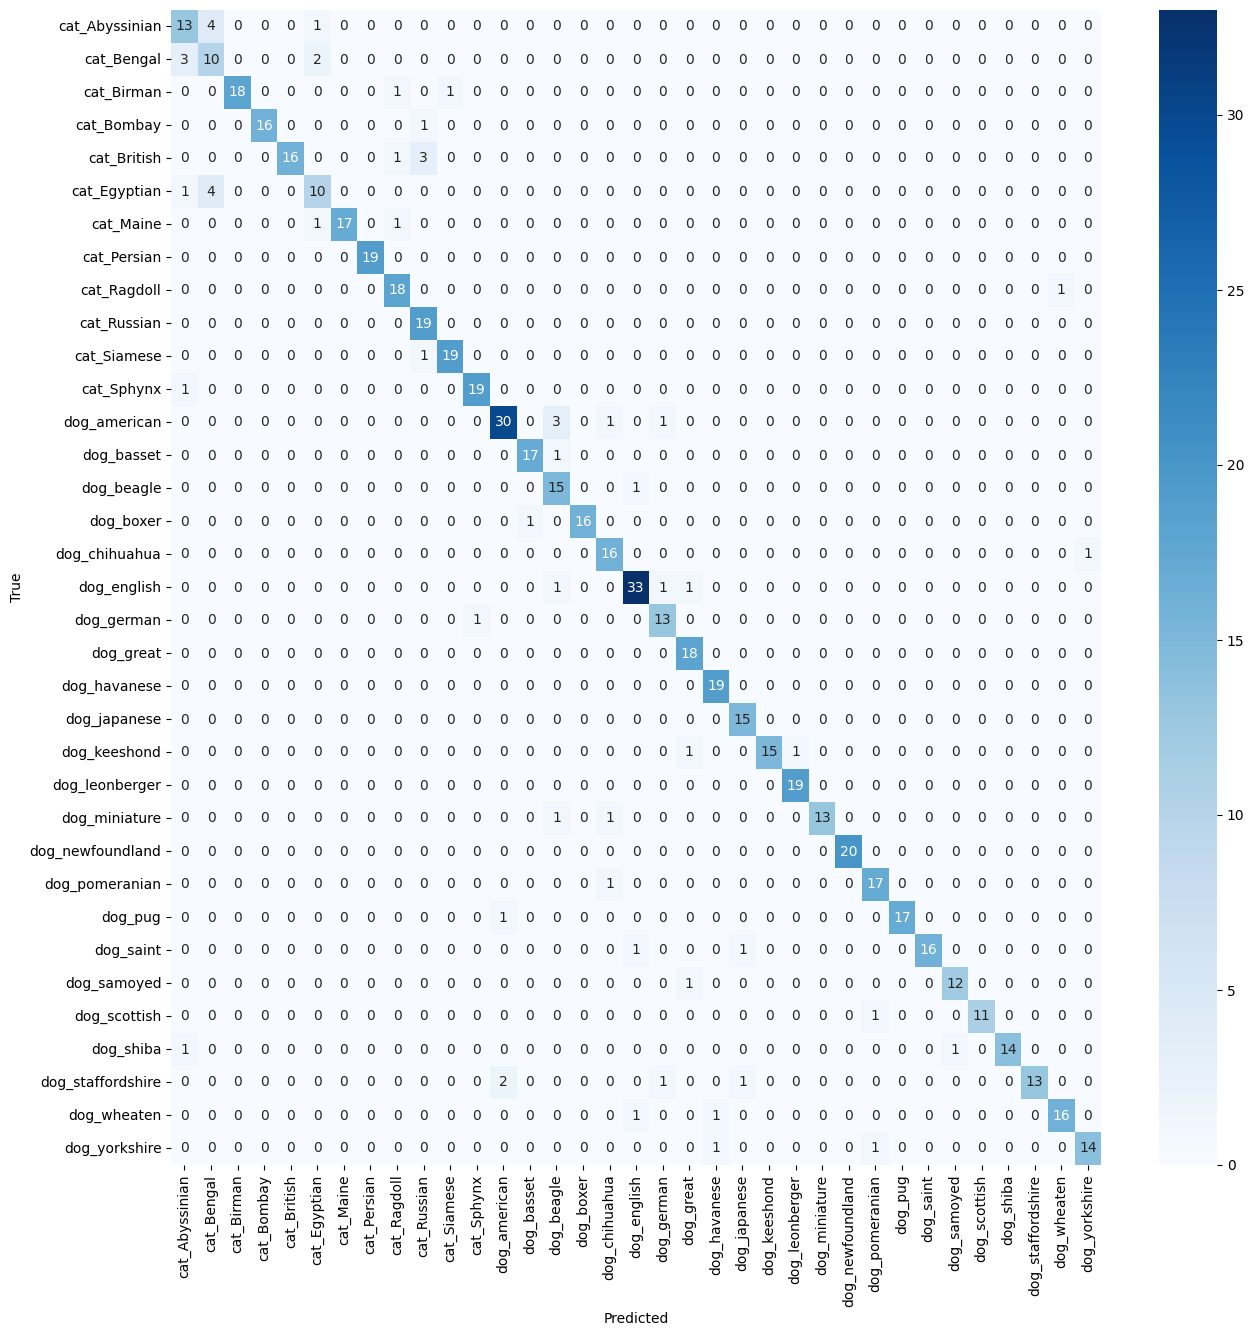

In [28]:
# Confusion Matrix
def plot_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, val_loader)

In [29]:
# Top-3 Accuracy
def top_k_accuracy(model, loader, k=3):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, topk = torch.topk(outputs, k, dim=1)
            for i in range(len(labels)):
                if labels[i] in topk[i]:
                    correct += 1
                total += 1
    
    return correct / total

top3_acc = top_k_accuracy(model, val_loader, k=3)
print(f'Top-3 Accuracy: {top3_acc:.4f}')

Top-3 Accuracy: 0.9689


### Выводы: Сравнение результатов модели до и после оптимизации

#### 1. Модель до оптимизации (без использования предобученной модели):
- Точность на валидации (Val Acc): Максимальная точность составила 0.62.
- Top-3 Accuracy: Точность топ-3 предсказаний достигла 0.85.
- Бинарная классификация (кошки vs собаки): Точность составила 0.94.
- Динамика обучения:
  - Обучение происходило медленно, с заметными колебаниями точности на валидационном наборе данных.
  - Разрыв между обучающей и валидационной точностью указывает на переобучение модели.
- Проблемы:
  - Низкая точность мультиклассовой классификации (породы).
  - Необходимость увеличения объема данных или улучшения архитектуры для повышения обобщающей способности.

---

#### 2. Модель после оптимизации (использование предобученной ResNet18):
- Точность на валидации (Val Acc): Максимальная точность значительно улучшилась и достигла 0.9222.
- Top-3 Accuracy: Точность топ-3 предсказаний также выросла до 0.9689, что демонстрирует высокую уверенность модели в своих предсказаниях.
- Бинарная классификация (кошки vs собаки): Точность возросла до 0.9907, что практически идеальный результат.
- Динамика обучения:
  - Модель показала быстрое обучение: уже на первых эпохах точность на валидации превысила 0.85.
  - Потери на обучающем наборе данных стремительно снижались, что говорит о хорошей сходимости модели.
  - Колебания точности на валидации стали менее выраженными, что указывает на улучшение обобщающей способности модели.
- Преимущества:
  - Использование предобученной модели позволило эффективно использовать признаки, извлеченные на больших датасетах (например, ImageNet).
  - Fine-tuning помог адаптировать модель под конкретную задачу, сохранив высокую точность.

---

#### 3. Основные выводы:
1. Значительное улучшение точности:
   - Применение предобученной модели ResNet18 позволило существенно повысить точность как мультиклассовой, так и бинарной классификации.
   - Модель стала лучше различать породы кошек и собак, что подтверждается ростом точности с 0.62 до 0.9222.

2. Улучшение top-3 accuracy:
   - Топ-3 точность выросла с 0.85 до 0.9689, что делает модель более надежной в реальных задачах, где важно учитывать несколько наиболее вероятных классов.

3. Эффективность fine-tuning:
   - Предобученная модель ResNet18 успешно адаптировалась под задачу классификации пород домашних животных благодаря замене последнего слоя и fine-tuning на небольшом датасете.

4. Снижение переобучения:
   - Использование предобученных весов и меньший learning rate помогли снизить разрыв между обучающей и валидационной точностью, что свидетельствует о лучшей обобщающей способности модели.

5. Рекомендации для дальнейшего улучшения:
   - Добавить больше данных для обучения, чтобы модель могла лучше обобщать.
   - Экспериментировать с другими предобученными моделями (например, EfficientNet, MobileNet), которые могут быть более эффективными для данной задачи.
   - Применить дополнительные техники регуляризации (например, раннюю остановку, weight decay).